## What
This notebook is a quick research project I perfomed to test the efficacy of knowledge distilattion for "tiny" models. The model was close to the GPT-2 model in many parameters with some modern techniques added.  - thing 1
- thing 2
- thing 3
- etc.

This notebook is a research project that I conducted to test the efficacy of the results of (Yuxian Gu et. al) in their 2024 MiniLLM paper with what I will call "MicoLMs" (models with less than 200B parameters).

I first trained an entire 124M with inspiration taken from Andrej Karpathy and GPT-2 as well as Olmo. With this I created a modular LM trained on the 10B token subset of finewebEDU from Hugging Face. As you will see down below. the model outperformed GPT-2 124M on the hellaswag eval with far fewer training tokens. I then took that pretrained model and created a training framework for the MiniLLM implementation of reverse KLD loss with a teacher model to try to get the Olmo 1B model to transfer some of its intelligence down to the MicroLM.

To keep variables to a minimum, the only difference between the pretraining and the rKLD was the implemtation of the KLD itself. No architectural changes were made to the model. 

Both models we will evaluated during and after training on zero-shot and few-shot hellaswag, snli, and GLUE benchmarks to evaluate perfomance. Comparing the loss in this scenario is not relevant as the loss calculations are completely different.

## Hella Swag Eval

The hellaswag eval methodology was based off Andrej Karpathy's implementation. Because the models are so small, they dot have the reasoning ability to be shown a list of choices and pick a result so instead probability comparisons are used. The model is independently called four times, one for each multiple choice answer and the probabilities the model assigns to each choice is evaluated to confrim what result the model "chose".

Olmo 7B: 0.7338   
Olmo 1B: 0.6071
gpt-2 1.5B: 0.4893     
gpt-2 124M: 0.2955         
Qwen2.5-1.5B: XX.XX     
Qwen2.5-3B: XX.XX   
Qwen2.5-7B: XX.XX   

These results are what motivate the idea for this test. These larger models have a significaly higher hellaswag scores, especially given the fact that a random result would be ~0.25. The work of Yuxian et al. shows that for larger models (1B-7B) getting knowledge distilled into them is quiet fruitful and there methodology of reverse KLD is good at doing so. I will test if these results hold for even smaller models (124M).

In [1]:
"""
Loading the data for analysis
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_control = "logs/SLM-0.124B_final_control_model_log.txt"
path_rkld = "logs/SLM-0.124B_MiniLLM_KLD_log.txt"
# file_path_first = "logs/SLM-0.124B_log.txt"
data_final = pd.read_csv(path_control, sep=" ", header=None, names=["index", "label", "value"])
# data_first = pd.read_csv(file_path_first, sep=" ", header=None, names=["index", "label", "value"])
data_rkld = pd.read_csv(path_rkld, sep=" ", header=None, names=["index", "label", "value"])

control_train = data_final[data_final["label"] == "train"]
control_val = data_final[data_final["label"] == "val"]
control_hella = data_final[data_final["label"] == "hella"]
# train_data_first = data_first[data_first["label"] == "train"]
# val_data_first = data_first[data_first["label"] == "val"]
# hella_data_first = data_first[data_first["label"] == "hella"]
rkld_train = data_rkld[data_rkld["label"] == "train"]
rkld_val = data_rkld[data_rkld["label"] == "val"]
rkld_hella = data_rkld[data_rkld["label"] == "hella"]

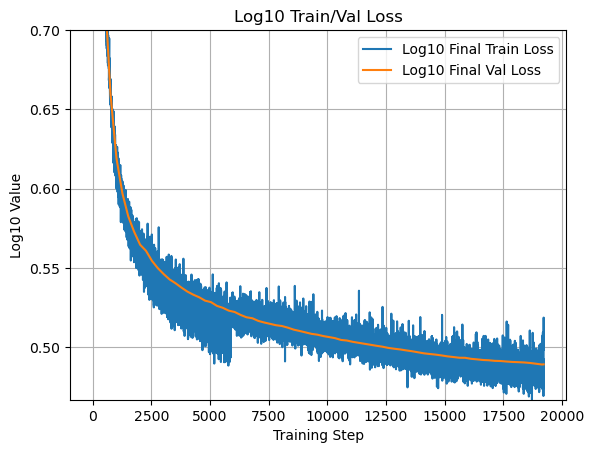

In [2]:
plt.plot(np.log10(control_train["value"]), label="Log10 Final Train Loss")
plt.plot(np.log10(control_val["value"]), label="Log10 Final Val Loss")

# plt.plot(np.log10(train_data_first["value"]), label="Log10 First Train Loss")
# plt.plot(np.log10(val_data_first["value"]), label="Log10 First Val Loss")

plt.xlabel('Training Step')
plt.ylabel('Log10 Value')
plt.title('Log10 Train/Val Loss')
plt.ylim(min(np.log10(control_train["value"])), 0.7)
plt.legend()
plt.grid(True)

For reference here was the val and train loss for the base MicroLM

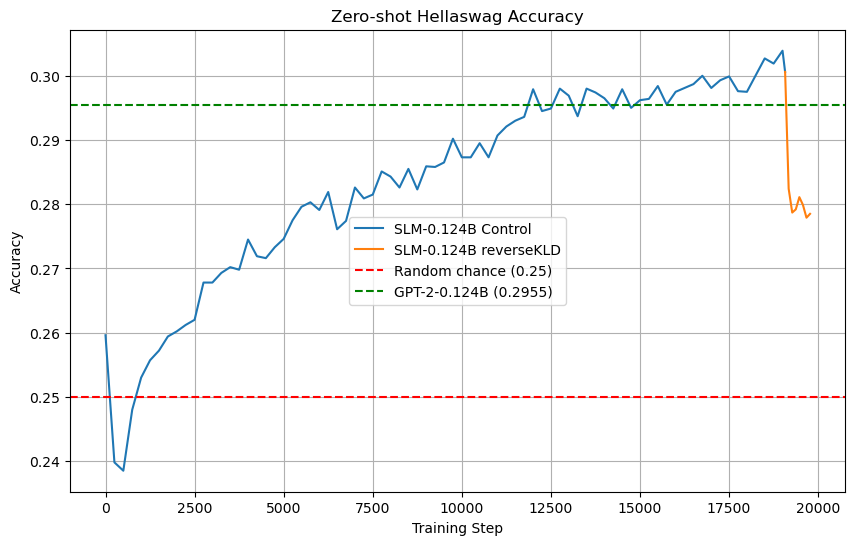

In [3]:
plt.figure(figsize=(10, 6))

rkld_hella_idx = rkld_hella["index"] + max(control_hella["index"])

plt.plot(control_hella["index"], control_hella["value"], label="SLM-0.124B Control")
# plt.plot(hella_data_first["value"], label="SLM-0.124B First")
plt.plot(rkld_hella_idx, rkld_hella["value"], label="SLM-0.124B reverseKLD")
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.title('Zero-shot Hellaswag Accuracy')

# Add a dotted line at y = 0.25 for random chance accuracy
plt.axhline(y=0.25, color='red', linestyle='--', label='Random chance (0.25)')
plt.axhline(y=0.2955, color='green', linestyle='--', label='GPT-2-0.124B (0.2955)')

plt.legend()
plt.grid(True)

The plot shows that the control model, using the given improved training methods and data outperforms the 124M checkmark of GPT-2.  

The training process for reverseKLD was computational expensive as you would have to evaluate all data twice, once through a much larger model as well so the training process was much slower. The model training method was tested with a variety of hyperparameters (length, alpha, lr) but all changes had similar results. The model did not generalize well and actually got worse. 

I believe these results occur from the size of the model just being too small. I believe the idea of superposition may have a lot to do with this. It is believed via the idea of superposition that the amount of facts that can be stored goes up exponentially with parameter size because the amount of "directions" that can be linked to characteristcs rises exponentially with dimension. Even with the high level of smoothing, the smaller model could not generalize the results in any meaningful way because the larger training models have too great an amount of j for such a small model. As you can see from (Yuxian et. al) For larger student models, they have enough dimensionality to still distill some of the information from the teacher models. 